---
title: 13.4 Stochastic Gradient Descent
subject:  Optimization
subtitle: 
short_title: 13.4 Stochastic Gradient Descent
authors:
  - name: Nikolai Matni
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: nmatni@seas.upenn.edu
license: CC-BY-4.0
keywords: 
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
---

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/12_Ch_13_Optimization/144-SGD.ipynb)

{doc}`Lecture notes <../lecture_notes/Lecture 23 - Stochastic Gradient Descent, Linear Classification and the Perceptron Algorithm, Multilayer Perceptrons.pdf>`

## Reading

Material related to this page, as well as additional exercises, can be ...

## Learning Objectives

By the end of this page, you should know:
- why naive backpropagation is computationally inefficient
- the Stochastic Gradient Descent Algorithm
- what is Perceptron and how it is used for linear classification
- single and multilayer perceptrons, and the importance of activiation functions

## Naive Backpropagation

In the previous lecture, motivated by machine learning applications, we discussed how to apply gradient descent to solve the following optimization problem:

\begin{equation}
\label{L}
\text{minimize } \text{loss}((\vv z_i,\vv y_i); \vv x) = \text{minimize } \sum_{i=1}^N\ell(\vv m(\vv z_i;\vv x)-\vv y_i) 
\end{equation}

over the parameters $\vv x$ of a model $\vv m$ so that $\vv m(\vv z_i;\vv x) \approx \vv y_i$ for all training data input/output pairs $(\vv z_i,\vv y_i)$, $i=1,\ldots,N$.

The bulk of our effort was spent on understanding how to compute the gradient of $\ell(\vv m(\vv z_i;\vv x)-\vv y_i)$ with respect to the model parameters $\vv x$, with a particular focus on models $\vv m$ that can be written as the following composition of models:

\begin{equation}
\label{DNN}
\vv O_0 &= \vv z_i \\
\vv O_1 &= \vv m_1(\vv O_0;\vv x_1), \quad \vv O_1 \in \mathbb{R}^{p_1}, \vv O_0 \in \mathbb{R}^{p_0} \\
\vv O_2 &= \vv m_2(\vv O_1;\vv x_2), \quad \vv O_2 \in \mathbb{R}^{p_2}, \vv O_1 \in \mathbb{R}^{p_1}  \\
&\vdots \\
\vv O_L &= \vv m_L(\vv O_{L-1};\vv x_L), \quad \vv O_L \in \mathbb{R}^{p_L}, \vv O_{L-1} \in \mathbb{R}^{p_{L-1}}
\end{equation}

which is the structure of contemporary models used in machine learning called _deep neural networks_ (we'll talk about these much more in this lecture). We made two key observations about the model structure that allowed us to effectively apply the matrix chain rule to compute gradients $\frac{\partial \ell}{\partial \vv x_1}, \ldots, \frac{\partial \ell}{\partial \vv x_L}$:

1) $\frac{\partial \ell}{\partial \vv x_j}$ only needs to compute partial derivatives of $\ell$ and layers $j, j+1, \ldots, L$;

2) If we start from layer $L$ $\left(\frac{\partial \ell}{\partial \vv x_L}\right)$ and work our way backwards we can
   (i) reuse previously computed partial derivatives, and
   (ii) save space on memory by exploiting that $\frac{\partial \ell}{\partial \vv m_L}$ is a row-vector.

The resulting algorithm is called _backpropagation_, and is a key enabling technology in modern machine learning. You will learn more about this in ESE 5460.

Now, despite all of this cleverness, when the model parameter vectors $\vv x_1, \ldots, \vv x_L$ and layer outputs $\vv O_1, \ldots, \vv O_L$ are very high dimensional (it is not uncommon for each $\vv x_i$ to have 100s of thousands or even millions of components) computing the gradient $\nabla_{\vv x} \ell(\vv m(\vv z_i;\vv x)-\vv y_i)$ of a single term in the sum [](#L) can be quite costly. Add to that the fact that the number of data points $N$ is often very large (order of millions in many settings), and we quickly run into some serious computational bottlenecks. And remember, this all just so we can run _a single iteration of gradient descent_. This may seem hopeless, but luckily, there is a very simple trick that lets us work around this problem: _stochastic gradient descent._

## Stochastic Gradient Descent (SGD) Algorithm 

Stochastic Gradient Descent (SGD) is the work horse algorithm of modern machine learning and has been rediscovered by various communities over the past 70 years, although it is usually credited to Robbins and Monro for a paper they wrote in 1951.

:::{note} Key Idea
Since our loss function can be written as a sum over examples, i.e.

\begin{equation}
\label{LL}
\text{loss}((\vv z_i,\vv y_i),\vv x) = \frac{1}{N} \sum_{i=1}^N \ell(\vv m(\vv z_i;\vv x)-\vv y_i) \quad (\text{loss}(\vv x) = \sum_i \ell_i(\vv x))
\end{equation}

then the gradient is also a sum: $\nabla_{\vv x} \text{loss} = \frac{1}{N} \sum_{i=1}^N \nabla_{\vv x} \ell_i$. Therefore we expect each individual gradient $\nabla_{\vv x} \ell_i$ to have some useful information in it. SGD minimizes [](#LL) by following the gradient of a _single randomly selected_ example (_or a small batch of $B$ randomly selected samples_).
:::

The SGD algorithm can be summarized as follows: Start with an initial guess $\vv x^{(0)}$, and at each iteration $k=0,1,2,\ldots$, do:

(i) Select an index $i \in \{1,\ldots,N\}$ at random
(ii) Update
\begin{equation}
\label{SGD}
\vv x^{(k+1)} = \vv x^{(k)} - s^{(k)} \nabla_{\vv x} \ell_i(\vv x^{(k)}) \quad (\text{SGD})
\end{equation}

Using the gradient of only the $i^{th}$ loss term $\ell_i(\vv x) = \ell(\vv m(\vv z_i;\vv x)-\vv y_i)$.

As before, $s^{(k)} > 0$ is a step-size that can change as a function of the current iterate.

This method works shockingly well in practice and is computationally tractable as at each iteration, the gradient of only the $i^{th}$ loss term needs to be computed. Modern versions of this algorithm replace step (i) with a _mini-batch_, i.e., by selecting $B$ indices at random, and step (ii) replaces $\nabla_{\vv x} \ell_i(\vv x^{(k)})$ with the average gradient:

\begin{equation}
\label{avg_grad}
\frac{1}{B} \sum_{b=1}^B \nabla_{\vv x} \ell_b(\vv x)
\end{equation}

The overall idea behind why SGD works (take ESE 6050 if you want to see a rigorous proof) is that while each individual update [(SGD)](#SGD) may not be an accurate gradient for the overall loss function loss$(\vv x)$, we are still following $\nabla_{\vv x} \text{loss}(\vv x)$ "on average". This also explains why you may want to use a mini-batch $B$ to compute a better gradient estimate [](#avg_grad), as having more loss terms leads to a better approximation of the true gradient. The tradeoff here is that as $B$ becomes larger, computing [](#avg_grad) is more computationally demanding.

## Linear Classification and the Perceptron

An important problem in machine learning is that of binary classification. In one of the case studies, you saw how to use least squares to solve this problem. Here, we offer an alternate perspective that will lead us to one important historical reason for the emergence of deep neural networks.

The problem set up for _linear binary classification_ is as follows. We are given a set of $N$ vectors $\vv z_1,\ldots,\vv z_N \in \mathbb{R}^n$ with associated binary labels $y_1,\ldots,y_N \in \{-1,+1\}$. The objective in linear classification is to find an affine function $\vv x^T\vv z+v$, defined by unknown parameters $\vv x \in \mathbb{R}^n$ and $v \in \mathbb{R}$, that _strictly separates_ the two classes. We can pose this as finding a feasible solution to the following _linear inequalities_:

\begin{equation}
\label{LC}
\begin{cases}
\vv x^T\vv z_i + v > 0 & \text{if } y_i = +1 \\
\vv x^T\vv z_i + v < 0 & \text{if } y_i = -1
\end{cases}
\end{equation}

The geometry of this problem is illustrated below.

:::{figure}../figures/14-lin_class.jpg
:label:lin_class
:alt:Linear classification
:width: 400px
:align: center
:::

There are three key components:

1) The _separating hyperplane_ $H = \{\vv z \in \mathbb{R}^n : \vv x^T\vv z+v = 0\}$. This is the set of vectors $\vv z \in \mathbb{R}^n$ that lie on the subspace $H$, which is the solution set to the linear equation

$$
\vv x^T\vv z = -v.
$$

The coefficient matrix here is $\vv x^T \in \mathbb{R}^{1\times n}$, and so rank Col$(\vv x^T) = 1$. This tells us that $\dim \text{Null}(\vv x^T) = \dim H = n-1$. In $\mathbb{R}^2$, this is the equation of a line:

$$
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}^T \begin{bmatrix} z_1 \\ z_2 \end{bmatrix} + v = x_1z_1 + x_2z_2 + v = 0 \Rightarrow z_2 = -\frac{x_1}{x_2}z_1 - \frac{v}{x_2}
$$

In $\mathbb{R}^3$, this is the equation of a plane with normal vector $\vv x$ going through point $v$ and in $\mathbb{R}^n$ is called a _hyperplane_. A key feature of a hyperplane is that it splits $\mathbb{R}^n$ into two _half-spaces_, i.e., the subsets of $\mathbb{R}^n$ on either side.

2) The half-space $H^+ = \{\vv z \in \mathbb{R}^n : \vv x^T\vv z+v > 0\}$, which is the "half" of $\mathbb{R}^n$ for which $\vv x^T\vv z+v > 0$. We want all of our positive $\textcolor{blue}{(+)}$ examples to live here.

3) The half-space $H^- = \{\vv z \in \mathbb{R}^n : \vv x^T\vv z+v < 0\}$, which is the "half" of $\mathbb{R}^n$ for which $\vv x^T\vv z+v < 0$. We want all $\textcolor{red}{(-)}$ examples to live here.

:::{figure}../figures/14-pos_neg.jpg
:label:pos_neg
:alt:Positive Negative
:width: 400px
:align: center
:::


The problem of finding the parameters $(\vv x,v)$ defining the classifier in [](#LC) can be solved using _linear programming_, a kind of optimization algorithm that you'll learn about in ESE 3040 and ESE 6050. It can also be solved using SGD as applied to a special loss function called the _hinge loss_:

$$
\text{loss}((\vv z_i,y_i);(\vv x,v)) = \frac{1}{N} \sum_{i=1}^N \max\{1-y_i(\vv x^T\vv z+v), 0\},
$$

which is a commonly used loss function for classification (you'll learn why in your Machine Learning classes).

The reason we are taking this little digression is that applying SGD to the hinge loss gives us _The Perceptron Algorithm_:

1. Initialize initial guess $(\vv x^{(0)},\vv v^{(0)})$
2. For each iteration $k=0,1,2,\ldots$, do:
    - Draw a random index $i \in \{1,\ldots,N\}$ 
    - If $y_i\left(\left(\vv x^{(k)}\right)^T \vv z_i+v^{(k)}\right) < 1$: Update
   \begin{equation}
   \label{update}
   (\vv x^{(k+1)},v^{(k+1)}) = (\vv x^{(k)},v^{(k)}) + y_i\begin{bmatrix} \vv z_i \\ 1 \end{bmatrix}
   \end{equation}
    Else, if $y_i(\vv x^{(k)})^T\vv z_i+v^{(k)}) \geq 1$, do not update $(\vv x^{(k+1)},v^{(k+1)}) = (\vv x^{(k)},v^{(k)})$.

This algorithm goes through the examples $(\vv z_i,y_i)$ one at a time, and updates the classifier only when it makes a mistake [](#update). The intuition is it "nudges" the classifier to be "less" wrong by $\|\vv z_i\|^2+1$ on any example $(\vv z_i,y_i)$ it currently misclassifies.

This incremental update works, and you can show that if there exists a solution to [](#LC), the perceptron algorithm will find it. People got _REALLY EXCITED ABOUT THIS_. See [below](#NYT) for a NYT article about the perceptron algorithm, which in hindsight seems a little silly given that we now know it's just SGD applied to a particular loss function. But then again, so is most of today's AI!

:::{figure}../figures/14-NYT.jpg
:label:NYT
:alt:NYT_perceptron
:width: 600px
:align: center
:::

## Single and Multi Layer Perceptrons

Given the excitement about the Perceptron, why do we not use them anymore? It turns out, it is very easy to stump! Consider the following set of positive and negative examples:


:::{figure}../figures/14-perc_fail.jpg
:label:perc_fail
:alt:XOR
:width: 400px
:align: center
:::

[These](#perc_fail) define an XOR function: the positive examples are in quadrants where $\text{sign}(z_1) \neq \text{sign}(z_2)$ and the negative ones are in quadrants for which $\text{sign}(z_1) = \text{sign}(z_2)$. These can't be separated by a linear classifier!


But suppose we were allowed to have two classifiers, and then combine them using a nonlinearity?

:::{figure}../figures/14-nonlinear.jpg
:label:nonlinear
:alt:nonlinear
:width: 400px
:align: center
:::

In the [image above](#nonlinear), we define a _pink classifier_ that returns _$f_1(\vv z) = z_1$_, a _purple classifier_ that returns _$f_2(\vv z) = -z_2$_. If we define our output to be

$$
f(\vv z) = f_1(\vv z) f_2(\vv z) = -z_1 z_2,
$$

then we see that this 'works':

:::{table} Nonlinear classifier
:label: table1
:align: center

|     | 1 | 2 | 3 | 4 |
| --- | ---        | ---       |---              |---    |
| Sign $f_1(\vv z)$ | +1 | -1 | -1 | +1 |
| Sign $f_2(\vv z)$ | -1 | -1 | +1 | +1 |
| Sign $f(\vv z)$ | -1 | +1 | -1| +1 |

:::

This 'worked'! The two key ingredients here are:
1. Having intermediate computation, called _hidden layers_
2. Allowing for some nonlinearity.

These two ingredients are combined to define the _Multilayer Perceptron (MLP)_.

:::{prf:definition} Multilayer Perceptron (MLP)
:label: mlp_defn
A _single hidden layer MLP_ is defined by the equations:

\begin{equation}
\label{mlp_eqn}
\vv h &= \sigma(W_1 \vv z + \vv b_1) \\
\vv o &= W_2 \vv h + \vv b_2
\end{equation}

The key features of [](mlp_eqn) are:
- An element-wise nonlinearity $\sigma$, called an _activation function._
- The input is $\vv z \in \mathbb{R}^n$.
- The _hidden layer_ is defined by a _weight matrix_ $W_1 \in \mathbb{R}^{p_1 \times n}$ and a _bias vector_ $\vv b_1 \in \mathbb{R}^{p_1}$
- The _output layer_ is defined by a weight matrix $W_2 \in \mathbb{R}^{p \times p_1}$ and bias vector $\vv b_2 \in \mathbb{R}^{p}$
- The overall map maps input $\vv z \in \mathbb{R}^n$ to output $\vv o \in \mathbb{R}^p$.
:::

In practice, [](#mlp_eqn) is trained to find $W_1, W_2, \vv b_1, \vv b_2$ using SGD and backpropagation.

:::{note} Why do we need a nonlinear activation function?

Suppose we didn't include $\sigma(\cdot)$, and defined our MLP as $\vv h = W_1 \vv z + \vv b_1$, $\vv o = W_2 \vv h + \vv b_2$. If we eliminate the hidden layer variable $\vv h$, we get

$$
\vv o &= W_2(W_1 \vv z + \vv b_1) + \vv b_2 = \underbrace{W_2 W_1}_W \vv z + \underbrace{W_2 \vv b_1 + \vv b_2}_{\vv b} \\ 
&= W\vv z + \vv b.
$$

This shows that we do not increase the expressivity of our model; as without the activation function, our model class reduces to affine functions. In some sense, this nonlinearity is the "secret sauce" of MLPs.
:::

Some common activation functions include:

1. The _Sigmoid function_:

:::{figure}../figures/14-sigmoid.jpg
:label:sigmoid
:alt:sigmoid
:width: 500px
:align: center
:::

2. The _Rectified Linear Unit (ReLU)_:

:::{figure}../figures/14-relu.jpg
:label:relu
:alt:relu
:width: 400px
:align: center
:::

Which activation function to use is a bit of an art, but there are generally accepted tricks of the trade that you'll learn about in ESE 5460. There are also many more than these two, with new ones being invented.

## Deep MLPs

There is nothing preventing us from adding more hidden layers. The $L$-hidden-layer
MLP is defined as:

\begin{align*}
\vv h_1 &= \sigma(W_1 \vv x + \vv b_1) \\
\vv h_2 &= \sigma(W_2 \vv h_1 + \vv b_2) \\
&\vdots \\
\vv h_L &= \sigma(W_L \vv h_{L-1} + \vv b_L) \\
\vv o &= W_{L+1} \vv h_L + \vv b_{L+1}
\end{align*}

Shown [below](#3_mlp) is an example with 3 hidden layers.

:::{figure}../figures/14-3_mlp.jpg
:label:3_mlp
:alt:3_mlp
:width: 300px
:align: center
:::

The important thing to notice is these functions are compatible with our discussion on backpropagation, meaning computing gradients with respect to the parameters $W_1,\ldots,W_{L+1}, \vv b_1,\ldots,\vv b_{L+1}$ can be done efficiently!

#### Python Break: Autodifferentiation in PyTorch!

In this example, we'll show how to take advantage of autodifferentiation in the `PyTorch` machine learning library in order to efficiently train machine learning models in code.

<!-- **TO DO** show how to take advantage of _autodifferentiation_ to
efficiently train MLPs in code. -->

For our first example, we will take a look at [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). In logistic regression, we have the following:

* A dataset $D$ of pairs of the form $(\vv x, y)$, where $\vv x \in \mathbb{R}^n$ is a vector with real-valued entries, and $y \in \{0, 1\}$ is a boolean-valued label.

* A class of models $f_{\vv a, b}(\vv x)$ of "logistic functions", where $a\in \mathbb{R}^n$, $b\in \mathbb{R}$, and $f_{\vv a, b}(\vv x) = \frac{1}{1 + \exp(-\vv a^\top \vv x + b)}$. A few things to note; the range of any logistic function is $(0, 1)$, i.e., these logistic functions only output values between 0 and 1; this is good when we want to learn boolean-valued labelings of our data. Also, try to convince yourself that for any value $v \in (0, 1)$, the set of all $\vv x$ such that $f_{\vv a, b}(\vv x) = v$ is the solution set to an *inhomogenous* linear system. Furthermore, convince yourself that the set of all $\vv x$ such that $f_{\vv a, b}(\vv x) = 0.5$ is the solution to a *homogeneous* linear system; we will call this set the *decision boundary*.

* A *binary cross-entropy* loss (or log-loss) function $l$ which measures the loss of our model $f_{\vv a, b}(\vv x)$ on the dataset $D = \{(\vv x_i, y)\}_{i = 1, \dots, M}$, defined by:

$$
\text{Loss}(f_{\vv a, b}(\vv x), D) = -\sum_{i = 1}^{M}{ y_i \cdot \log f_{\vv a, b}(\vv x) + (1 - y_i) \cdot \log (1 - f_{\vv a, b}(\vv x))}
$$

To give some high-level intuition, the *binary cross-entropy* loss is smaller when, on average, the values of $f_{\vv a, b}(\vv x_i)$ are close to $y_i$. This has a very nice interpretation in terms of probabilities, but for now we will focus on the optimization aspects of logistic regression.

In many machine learning scenarios, the objective is to choose the model $f_{\vv a, b}(\vv x)$ with the lowest loss on the dataset $D$ (this is known as *empirical risk minimization*). In our scenario, we can formulate this as an optimization problem:

$$
&\text{Minimize (over $\vv a, b$): $\text{Loss}(f_{\vv a, b}(\vv x), D)$}
$$

In the case of logistic regression with log-loss, this is actually a convex loss which means that gradient descent will find the global minimum (if done correctly)! This is exactly what the code snippet below is doing; note that we labeled each section of the code; we will explain what each section does in a bit.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/12_Ch_13_Optimization/144-SGD.ipynb)


Epoch [1000/10000], Loss: 0.6212
Epoch [2000/10000], Loss: 0.5708
Epoch [3000/10000], Loss: 0.5320
Epoch [4000/10000], Loss: 0.5018
Epoch [5000/10000], Loss: 0.4778
Epoch [6000/10000], Loss: 0.4583
Epoch [7000/10000], Loss: 0.4424
Epoch [8000/10000], Loss: 0.4291
Epoch [9000/10000], Loss: 0.4180
Epoch [10000/10000], Loss: 0.4085
Accuracy: 83.70%


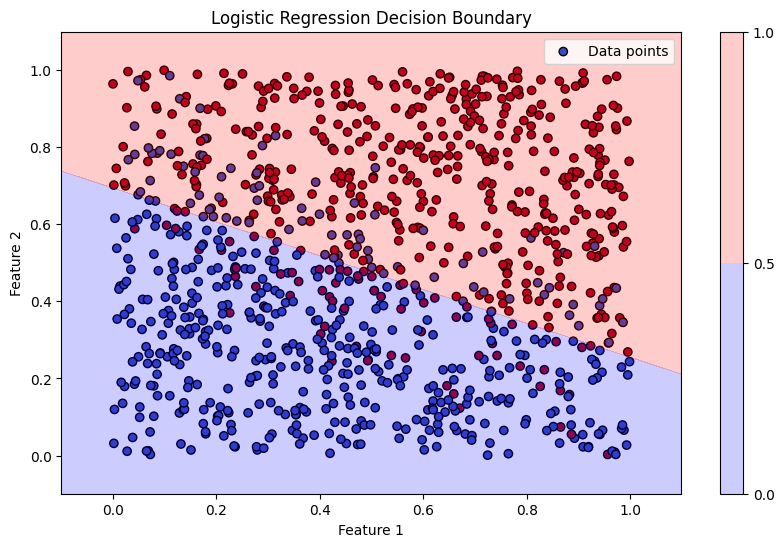

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(541)

# (A) Generate a random dataset
X = torch.rand(1000, 2)
Y = torch.round(0.25 * X[:, 0] + 0.45 * X[:, 1] + 0.3 * torch.rand(1000))

# (B) Define a logistic regression model using a single linear layer
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.a = nn.Parameter(torch.zeros(2))  
        self.b = nn.Parameter(torch.tensor(0.0))  
    
    def forward(self, x):
        return torch.sigmoid(torch.matmul(x, self.a.T) + self.b)

# (C) Instantiate the model
model = LogisticRegressionModel()

# (D) Define the loss function and optimizer
criterion = nn.BCELoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01)

# (E) Train the model
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, Y)
    
    # Backward pass and optimization
    optimizer.zero_grad() 
    loss.backward()      
    optimizer.step()     
    
    # Print loss every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# (F) Testing the model
with torch.no_grad():
    predicted = model(X)
    predicted_labels = predicted.round()
    accuracy = (predicted_labels.eq(Y).sum().item()) / Y.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')

# (G) Plotting the dataset, labels, and decision boundary
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y.squeeze(), cmap='coolwarm', marker='o', edgecolor='k', label='Data points')
x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
grid_tensor = torch.tensor(np.c_[xx1.ravel(), xx2.ravel()], dtype=torch.float32)
with torch.no_grad():
    probs = model(grid_tensor).reshape(xx1.shape)
plt.contourf(xx1, xx2, probs, levels=[0, 0.5, 1], alpha=0.2, colors=['blue', 'red'])
plt.colorbar()
plt.title('Logistic Regression Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper right')
plt.show()

Here, we'll explain what each labeled section does and connect these functions to ideas we have already learned:

* **(A)** This is just generating a random dataset.

* **(B)** Here, we define a model class. Logistic models, which we have denoted by $f_{\vv a, \vv b}(\vv x)$, are parameterized by two weights: $\vv a$ and $b$. We indicate that this are weights that the optimizer should optimize over by declaring them as `nn.Parameter`. (The `torch.tensor` class is an analog to `np.array`.) The `forward` function evaluates our function on a batch of data, i.e., evaluates its output on a bunch of points at once; this is done for computational efficiency reasons.

* **(C)** Here, we are generating an instance of our model with initial weights set to zero.

* **(D)** Here, we indicate that we want to use the stochastic gradient descent algorithm to fit $\vv a$ and $\vv b$ such as to minimizer the binary cross entropy loss on our dataset.

* **(E)** TO DO TODO

* **(F)**

* **(G)**
